In [231]:
#Import Libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

pd.options.mode.chained_assignment = None  
pd.set_option('display.max_columns',80)  # or 1000
pd.set_option('display.max_rows', 100)  # or 1000

from sklearn import preprocessing


import ast #For converting string to list

#For EDA (Location Visualizations)
import folium
import json 

import warnings
warnings.filterwarnings('ignore')

In [201]:
#Import dataset
df_raw = pd.read_csv('listings.csv')

#Checking Shape
print(f'{df_raw.shape[0]} examples, {df_raw.shape[1]} features')

# ... and duplicates
print("It contains {} duplicates.".format(df_raw.duplicated().sum()))


24551 examples, 106 features
It contains 0 duplicates.


In [202]:
# Deciding which columns to work with

#1 City, street, state are mostly same for all, id is unique and scrape_id is same for all.
#2 experiences_offered, thumbnail_url, medium_url are  empty
#3 picture_url, host_thumbnail_url, host_picture_url links are broken.

columns_to_discard = ['city','scrape_id','experiences_offered','thumbnail_url','medium_url',
                     'picture_url','xl_picture_url','host_acceptance_rate','host_thumbnail_url',
                     'host_picture_url','street','state','market','smart_location','country_code',
                     'country','has_availability','calendar_last_scraped','license','jurisdiction_names',
                     'is_business_travel_ready','host_name','square_feet',
                     'calendar_updated','host_id','zipcode']

#Columns with working link: Can be used for data scraping
linked_columns= ['listing_url','host_url']

#Columns that can be analyzed with NLP
text_columns = ['name','summary','space','description','neighborhood_overview',
               'notes','transit','access','interaction','house_rules','host_about']

#Date columns can be feature-engineered
date_columns = ['host_since','first_review','last_review',]

#Categorical columns (will be converted to categories)
cat_columns = ['last_scraped','host_response_time','host_response_rate','host_is_superhost',
              'host_neighbourhood','host_verifications','host_has_profile_pic','host_identity_verified',
              'neighbourhood','neighbourhood_cleansed','neighbourhood_group_cleansed','is_location_exact',
              'property_type','room_type','bed_type','amenities','calendar_updated','requires_license',
              'instant_bookable','cancellation_policy','require_guest_profile_picture',
               'require_guest_phone_verification']

target_column = 'price'

print(len(df_raw.columns),'total column count\n')
print(len(columns_to_discard), 'useless columns')
print(len(linked_columns),'columns with link included')
print(len(text_columns),'text columns')
print(len(date_columns),'date type columns')
print(len(cat_columns),' categorical columns')

106 total column count

26 useless columns
2 columns with link included
11 text columns
3 date type columns
22  categorical columns


### Notes:

* Interesting feature is text german or english
* Didn't understand host_listings_count and host_total_listings_count (will look more closely)
They are almost same (only 51 of them different from 24551)
* Zipcode should be investigated more (to understand the correlation between numbers and location
if there is any.)
* How bathrooms can be a decimal number like 2.5 =)
* Square_feet, weekly/monthly prices are mostly NaN
* What is the difference between minimum_nights vs minimum_minimum_nights (23748 of them are same)
* Interesting visualizations for review columns (Average is not 5 for example. So we may shift the average)
* host_neighbourhood can be processed as inside the city vs outside the city. (Need Berlin's neighbourhoods)


In [203]:
#Check if there is any nan value in price
print(df_raw.price.isna().sum())
print('Price data doesnt have any null, which means we can use the full dataset for prediction model')

0
Price data doesnt have any null, which means we can use the full dataset for prediction model


In [204]:
#Dropping useless columns
def drop_useless_columns(df):
    temp = df.copy()   
    temp= temp.drop(columns= columns_to_discard)
    
    print('shape of df:',temp.shape)
    print(len(columns_to_discard),'useless columns are dropped')
    
    return temp

df_raw = drop_useless_columns(df_raw)

shape of df: (24551, 80)
26 useless columns are dropped


In [205]:
#Dropping text columns ( will handle them seperately after)
def drop_text_columns(df):
    temp = df.copy()
    temp_columns = text_columns + linked_columns
    temp = temp.drop(columns = temp_columns)

    print('shape of df:',temp.shape)
    print(len(temp_columns),'text columns are dropped')
    
    return temp

df_raw = drop_text_columns(df_raw)

shape of df: (24551, 67)
13 text columns are dropped


## Preprocessing the Data


In [206]:
#Finding NaN values
def print_nan_counts(df):
    print('Column Name: NaN Count')
    print('-----------------------')
    for column in df.columns:
        if any(df[column].isna()):
            print(column,':' ,df[column].isna().sum())

print_nan_counts(df_raw)

Column Name: NaN Count
-----------------------
host_since : 51
host_location : 143
host_response_time : 10452
host_response_rate : 10452
host_is_superhost : 51
host_neighbourhood : 5186
host_listings_count : 51
host_total_listings_count : 51
host_has_profile_pic : 51
host_identity_verified : 51
bathrooms : 29
bedrooms : 19
beds : 31
weekly_price : 21248
monthly_price : 22175
security_deposit : 9624
cleaning_fee : 7280
first_review : 4328
last_review : 4328
review_scores_rating : 4819
review_scores_accuracy : 4845
review_scores_cleanliness : 4842
review_scores_checkin : 4864
review_scores_communication : 4847
review_scores_location : 4863
review_scores_value : 4866
cancellation_policy : 1
reviews_per_month : 4328


I decided to get rid of that 51 rows since in most of the columns they don't have any information. 6 columns are dropped.

In [207]:
#Get rid of that 51 empty rows:
df_raw = df_raw[df_raw['host_since'].isna() == False]

print('shape of df:',df_raw.shape)

shape of df: (24500, 67)


In [208]:
#intersection of two lists Return true if there is at least one intersection
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return len(lst3) != 0

In [209]:
#Categorize Host Location as Berlin, Outside of Berlin, Outside of Germany and Unknown
def categorize_host_location(df):
    
    temp = df.copy() 
    locations = []
    counter = 0
    words =['Germany','DE']

    for _,row in temp.iterrows():

        location = row['host_location']    
        location= str(location)
        word_list = location.split(', ')

        if 'Berlin' in word_list:
            locations.append('Berlin')

        elif intersection(words,word_list):
            locations.append('Outside-of-Berlin')
            
        elif word_list[0] =='nan':
            locations.append('Unknown')
        else:
            #print(location)
            locations.append('Outside of Germany')

    temp['host_location'] = locations       

    return temp


df_raw = categorize_host_location(df_raw)

In [210]:
#Categorize Host Neighbourhood get most popular 15 and labels others as "others"
def categorize_host_neighbourhood(df):
    temp = df.copy()
    popular_neighbourhoods = ['Neukölln', 'Prenzlauer Berg','Kreuzberg','Friedrichshain',
      'Mitte','Wedding','Schöneberg','Charlottenburg','Moabit',
      'Wilmersdorf','Pankow','Tempelhof','Rummelsburg','Weißensee','Tiergarten']
    
    hood_list=[]
    
    for hood in temp['host_neighbourhood']:
        if hood in popular_neighbourhoods:
            hood_list.append(hood)
        else:
            hood_list.append('other')
    
    temp['host_neighbourhood'] = hood_list
    
    return temp

df_raw = categorize_host_neighbourhood(df_raw)

In [211]:
#Replace NaN values with 0:
def replace_nan(df,column):
    temp = df.copy()
    temp[column] = temp[column].fillna('$0.00')
    
    return temp

#Probably they are not charging cleaning fee and security deposits that's why they are nan.
df_raw = replace_nan(df_raw,'cleaning_fee')
df_raw = replace_nan(df_raw,'security_deposit')

In [212]:
print_nan_counts(df_raw)

Column Name: NaN Count
-----------------------
host_response_time : 10401
host_response_rate : 10401
bathrooms : 29
bedrooms : 19
beds : 31
weekly_price : 21209
monthly_price : 22134
first_review : 4313
last_review : 4313
review_scores_rating : 4802
review_scores_accuracy : 4828
review_scores_cleanliness : 4825
review_scores_checkin : 4847
review_scores_communication : 4830
review_scores_location : 4846
review_scores_value : 4849
cancellation_policy : 1
reviews_per_month : 4313


I'm planning to use XgBoost for the model and since XgBoost has the capability of handling missing data during training.

In [213]:
#Removing $ sign in front of price
def convert_prices_into_float(df):
    temp = df.copy()
    
    price_columns = ['price','weekly_price','monthly_price','cleaning_fee','security_deposit','extra_people']
    for column in price_columns:
        temp[column] = temp[column].str.replace('$','').str.replace(',', '').astype(float)
        
    return temp

df_raw= convert_prices_into_float(df_raw)

In [244]:
#Get rid of prices equal to 0 or more than 500:
df_raw = df_raw[(df_raw['price'] != 0)]
df_raw = df_raw[(df_raw['price'] < 500)]

print('shape of df:',df_raw.shape)

shape of df: (24348, 72)


In [215]:
def categorize_ordinal_columns(df):
    temp = df.copy()
    cleanup_nums = {"room_type": {"Entire home/apt": 1, "Private room": 2, "Shared room": 3},
                   "cancellation_policy": {"flexible": 1, "moderate": 2, "strict": 3,
                                           "strict_14_with_grace_period": 3, "super_strict_30": 4,
                                          "super_strict_60": 5},
                   "bed_type": {"Real Bed": 1, "Pull-out Sofa": 2, "Futon": 3, 'Couch': 4, 'Airbed': 5}}
    temp =temp.replace(cleanup_nums)
    
    return temp
df_raw = categorize_ordinal_columns(df_raw)

In [216]:
 def categorize_columns(columns,df):
        le = preprocessing.LabelEncoder()
        temp = df.copy()
        
        for feature in columns:
            temp[feature] = le.fit_transform(temp[feature])
            
        return temp

In [217]:
#Columns to categorize
col_to_cat= ['host_location','host_response_time','host_is_superhost',
             'host_neighbourhood','neighbourhood_cleansed',
             'neighbourhood_group_cleansed',
             'require_guest_phone_verification','require_guest_profile_picture',
             'instant_bookable','requires_license','is_location_exact',
             'host_has_profile_pic','host_identity_verified',
             'property_type','neighbourhood']

#df_raw= categorize_columns(col_to_cat,df_raw)

In [218]:
#Create verification features:
def convert_string_to_list(string):
    return ast.literal_eval(string)

def create_verification_features(df):
    temp = df.copy()
    verifications = ['email','phone','facebook','reviews','government_id','selfie']
    
    temp.host_verifications = temp.host_verifications.apply(convert_string_to_list)

    for verification in verifications:
        temp[f'verification_{verification}'] = [True if verification in x else False for x in temp.host_verifications]
        
    temp.drop(columns=['host_verifications'],inplace=True)
        
    return temp

In [219]:
df_raw = create_verification_features(df_raw)

In [220]:
def categorize_amenities(df):
    temp = df.copy()
    #amenit_list= set()
    amenit_count = []
    for i,row in temp.iterrows():
        amenit_list= []
        for amenit in row['amenities'].split('{')[1].split('"'):
            if len(list(amenit)) !=1:
                #amenit = amenit.replace(',',' ')
                #amenit = amenit.replace('"',' ')
                amenit = amenit.replace(' ','')
                amenit = amenit.replace('}','')
                temp_list = amenit.split(',')     
                temp_list = [i for i in temp_list if i]
                amenit_list.extend(temp_list)
        #print(len(amenit_list))
        amenit_count.append(len(amenit_list))
                #amenit_list.update(temp_list)
    #print(amenit_list)

    temp['amenities_count'] = amenit_count
    temp.drop(columns = ['amenities'],inplace=True)
    
    return temp

In [221]:
#df_raw = categorize_amenities(df_raw)

In [222]:
def drop_percent(string):
    try:
        return int(string.replace('%',''))
    except:
        return np.nan

df_raw.host_response_rate = df_raw.host_response_rate.apply(drop_percent)

In [223]:
print('Columns with "object" type :')
[ column for column in df_raw.columns if df_raw[column].dtype == object ]

Columns with "object" type :


['last_scraped',
 'host_since',
 'host_location',
 'host_response_time',
 'host_is_superhost',
 'host_neighbourhood',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'is_location_exact',
 'property_type',
 'amenities',
 'first_review',
 'last_review',
 'requires_license',
 'instant_bookable',
 'require_guest_profile_picture',
 'require_guest_phone_verification']

The last columns that I didnt preprocessed are date columns. For now, I would drop these to continue my analysis. After creating the pipeline this part can be use for feature engineering.

## Exploratory Data Analysis

In [287]:
df = df_raw.copy()

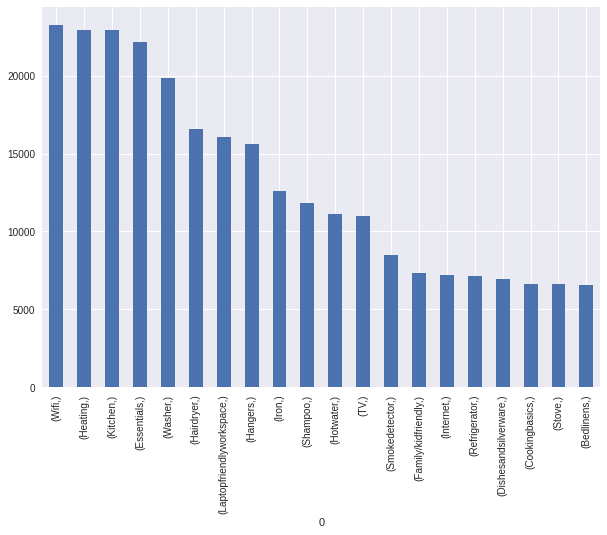

In [288]:
popular_amenities= {'Wifi','Heating','Kitchen','Essentials',
                    'Washer','Hairdryer','Laptopfriendlyworkspace',
                    'Hangers','Iron','Shampoo','Hotwater','TV','Smokedetector','Family/kidfriendly',
                    'Internet','Refrigerator','Dishesandsilverware','Cookingbasics','Stove','Bedlinens'}
amenit_list= []
for i,row in df.iterrows():
    for amenit in row['amenities'].split('{')[1].split('"'):
        if len(list(amenit)) !=1:
            #amenit = amenit.replace(',',' ')
            #amenit = amenit.replace('"',' ')
            amenit = amenit.replace(' ','')
            amenit = amenit.replace('}','')
            temp_list = amenit.split(',')     
            temp_list = [i for i in temp_list if i]
            #print(temp_list)
            amenit_list.extend(temp_list)
    
amenit_list = pd.DataFrame(amenit_list)
plot = amenit_list.value_counts().head(20).plot(kind='bar')

These are all essentials things, they didn't make me satisfy. Lets remove these common amenities and find out what hosts have more to offer

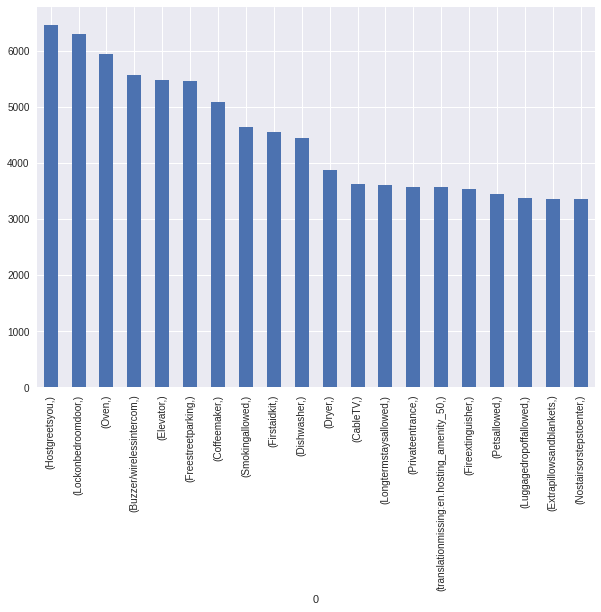

In [289]:
popular_amenities= {'Wifi','Heating','Kitchen','Essentials',
                    'Washer','Hairdryer','Laptopfriendlyworkspace',
                    'Hangers','Iron','Shampoo','Hotwater','TV','Smokedetector','Family/kidfriendly',
                    'Internet','Refrigerator','Dishesandsilverware','Cookingbasics','Stove','Bedlinens'}

all_amen = []
for i,row in df.iterrows():
    amenit_list= []
    for amenit in row['amenities'].split('{')[1].split('"'):
        if len(list(amenit)) !=1:
            #amenit = amenit.replace(',',' ')
            #amenit = amenit.replace('"',' ')
            amenit = amenit.replace(' ','')
            amenit = amenit.replace('}','')
            temp_list = amenit.split(',')     
            temp_list = [i for i in temp_list if i]
            #print(temp_list)
            amenit_list.extend(temp_list)
    list1 = [ele for ele in amenit_list if ele not in popular_amenities]
    all_amen.extend(list1)
    
all_amen = pd.DataFrame(all_amen)

plot = all_amen.value_counts().head(20).plot(kind='bar')


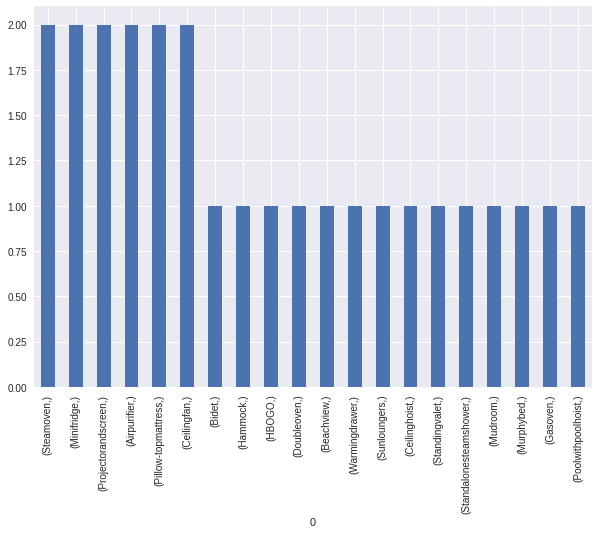

In [290]:
plot = all_amen.value_counts().tail(20).plot(kind='bar')

Well, I'm suprised there is only one private hot tub on Berlin AirBnb.


### Berlin's Map and Neighbourhoods
Let's see the distribution of price on Berlin's map.


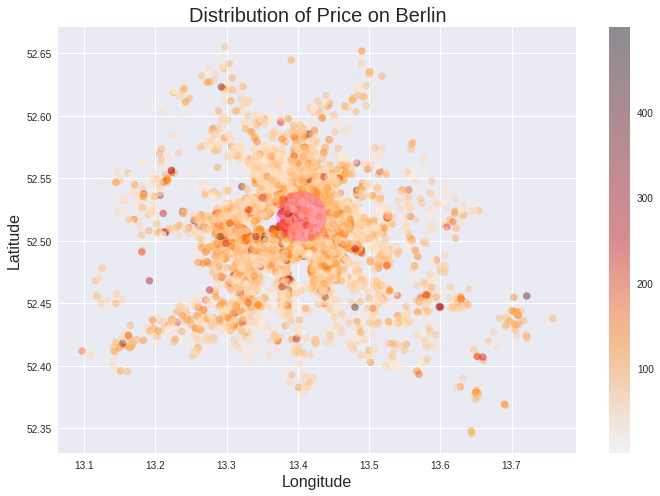

In [354]:
plt.rcParams['figure.figsize'] = [10, 7]

longitude = df['longitude']
latitude = df['latitude']
price = df['price']

#Berlin's Center Point (Looked from wikipedia):
berlin_lat= 52.5200
berlin_long = 13.4050

fig, ax = plt.subplots()

im = ax.scatter(x=longitude, y=latitude, alpha=0.4,
         c=price, cmap="gist_heat_r");


ax.scatter(x= berlin_long, y=berlin_lat,s=2500, c='magenta', alpha=0.2)



fig.colorbar(im, ax=ax)
ax.set_ylabel('Latitude', fontsize=16)
ax.set_xlabel('Longitude', fontsize=16)
ax.set_title('Distribution of Price on Berlin', fontsize = 20)
fig.tight_layout()

In [298]:
berlin_boroughs = "https://raw.githubusercontent.com/funkeinteraktiv/Berlin-Geodaten/master/berlin_bezirke.geojson"
berlin_price = df.groupby(by="neighbourhood_group_cleansed").mean().reset_index()
berlin_price = berlin_price.replace('Charlottenburg-Wilm.','Charlottenburg-Wilmersdorf')
berlin_price.neighbourhood_group_cleansed = berlin_price.neighbourhood_group_cleansed.str.replace(' ','')

In [382]:
geo_data = pd.read_json('berlin_bezirke.geojson')

hood_centers ={}
for i in range(len(geo_data)):
    
    name = geo_data.features[i]['properties']['name']
    coordinates =geo_data.features[i]['geometry']['coordinates']
    coordinates = coordinates[0][0]
    
    longs = []
    lats= []

    for point in coordinates:
        longs.append(point[0])
        lats.append(point[1])

    hood_long = sum(longs)/len(longs)
    hood_lat = sum(lats)/len(lats)
    
    hood_centers[name]= (hood_long,hood_lat)
    

In [387]:
berlin_map = folium.Map(location=[berlin_lat, berlin_long], zoom_start=11)
folium.Choropleth(
    geo_data=berlin_boroughs,
    name='choropleth',
    data=berlin_price,
    columns=['neighbourhood_group_cleansed', 'price'],
    key_on='feature.properties.name',
    fill_color="BuPu",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Average Price ($)"
).add_to(berlin_map)

folium.LayerControl().add_to(berlin_map)

#Lets add names of neighbourhoods
for hood in hood_centers:
    hood_long = hood_centers[hood][0]
    hood_lat = hood_centers[hood][1]
        
    html =f" <div style='color: white; background-color: brown ;text-align: center;font-family: serif;'>{hood}</div>"
    marker = folium.Marker(title='Mitte',location=[hood_lat,hood_long],
                          icon= folium.DivIcon(icon_size=(100,100),
                                               html=html))

    marker.add_to(berlin_map)

berlin_map

Text(0.5, 0, 'Count')

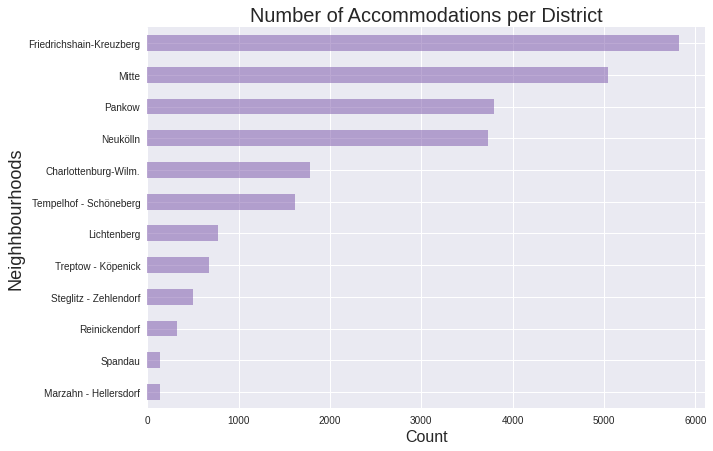

In [396]:
df['neighbourhood_group_cleansed'].value_counts().sort_values().plot(kind='barh', color='#7953a9', alpha=0.5)
plt.title('Number of Accommodations per District', fontsize=20);
plt.ylabel('Neighhbourhoods', fontsize=18)
plt.xlabel('Count', fontsize=16)

In [304]:
berlin_boroughs

'https://raw.githubusercontent.com/funkeinteraktiv/Berlin-Geodaten/master/berlin_bezirke.geojson'

In [305]:
import json

In [367]:
geo_data = pd.read_json('berlin_bezirke.geojson')

hood_centers ={}
for i in range(len(geo_data)):
    
    name = geo_data.features[i]['properties']['name']
    coordinates =geo_data.features[i]['geometry']['coordinates']
    coordinates = coordinates[0][0]
    
    longs = []
    lats= []

    for point in coordinates:
        longs.append(point[0])
        lats.append(point[1])

    hood_long = sum(longs)/len(longs)
    hood_lat = sum(lats)/len(lats)
    
    hood_centers[name]= (hood_long,hood_lat)
    

In [368]:
hood_centers

{'Mitte': (13.362790306902992, 52.52702762313426),
 'Friedrichshain-Kreuzberg': (13.429921028610366, 52.50347254359671),
 'Pankow': (13.425065249618733, 52.607731856126094),
 'Charlottenburg-Wilmersdorf': (13.287036872634642, 52.508559362445425),
 'Spandau': (13.190407309917338, 52.5325433487603),
 'Steglitz-Zehlendorf': (13.23618792056075, 52.430786257943915),
 'Tempelhof-Schöneberg': (13.37287086739133, 52.44762086847825),
 'Neukölln': (13.455644600750952, 52.44349992866085),
 'Treptow-Köpenick': (13.612304379943481, 52.426195810263685),
 'Marzahn-Hellersdorf': (13.577334216441193, 52.52360526742986),
 'Lichtenberg': (13.505971691947554, 52.53567586516852),
 'Reinickendorf': (13.319865743764165, 52.610013507180646)}

In [351]:
longs = []
lats= []

for point in mitte_coordinates:
    longs.append(point[0])
    lats.append(point[1])

mitte_long = sum(longs)/len(longs)
mitte_lat = sum(lats)/len(lats)

In [352]:
(mitte_long,mitte_lat)

(13.429921028610366, 52.50347254359671)

In [384]:
for hood in hood_centers:
    print(hood_centers[hood])

(13.362790306902992, 52.52702762313426)
(13.429921028610366, 52.50347254359671)
(13.425065249618733, 52.607731856126094)
(13.287036872634642, 52.508559362445425)
(13.190407309917338, 52.5325433487603)
(13.23618792056075, 52.430786257943915)
(13.37287086739133, 52.44762086847825)
(13.455644600750952, 52.44349992866085)
(13.612304379943481, 52.426195810263685)
(13.577334216441193, 52.52360526742986)
(13.505971691947554, 52.53567586516852)
(13.319865743764165, 52.610013507180646)
